In [38]:
def generate_hard_data_spatial(n1_lb, n1_ub, n2_lb, n2_ub, n3_lb, n3_ub):

    n_samples_1 = math.floor(np.random.uniform(n1_lb, n1_ub, 1))  # floor for ints
    n_samples_2 = math.floor(np.random.uniform(n2_lb, n2_ub, 1))
    n_samples_3 = math.floor(np.random.uniform(n3_lb, n3_ub, 1))

    x1 = np.random.uniform(0, 3, n_samples_1)
    x2 = np.random.uniform(0, 3, n_samples_1)
    error_1 = np.random.normal(0, 2, n_samples_1)
    y1 = 2*x1 - 3*x2 + 30 + error_1
    true_cluster = 1
    longitude = np.random.normal(0, 1, n_samples_1)
    latitude = np.random.normal(0, 1, n_samples_1)

    data = pd.DataFrame({"long": longitude, "lat": latitude, "x1": x1, "x2": x2, "y1": y1, "true_clust": true_cluster})

    x1 = np.random.normal(0, 3, n_samples_2)
    x2 = np.random.normal(0, 3, n_samples_2)
    error_1 = np.random.normal(0, 2, n_samples_2)
    y1 = -2*x1 - 1.5*x2 + 70 + error_1
    true_cluster = 2
    longitude = np.random.normal(1.5, 1, n_samples_2)
    latitude = np.random.normal(1.5, 1, n_samples_2)

    data_temp = pd.DataFrame({"long": longitude, "lat": latitude, "x1": x1, "x2": x2, "y1": y1, "true_clust": true_cluster})
    data = pd.concat([data, data_temp], ignore_index=True)

    x1 = np.random.normal(0, 3, n_samples_3)
    x2 = np.random.normal(0, 3, n_samples_3)
    error_1 = np.random.normal(0, 2, n_samples_3)
    y1 = -3*x1-2*x2+0+error_1
    true_cluster = 3
    longitude = np.random.normal(-1.5, 1, n_samples_3)
    latitude = np.random.normal(-1.5, 1, n_samples_3)

    data_temp = pd.DataFrame({"long": longitude, "lat": latitude, "x1": x1, "x2": x2, "y1": y1, "true_clust": true_cluster})
    data = pd.concat([data, data_temp], ignore_index=True)

    return data

In [13]:
import math
import torch
import gpytorch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import pdist, squareform
from sklearn.model_selection import train_test_split
%matplotlib inline
%load_ext autoreload
%autoreload 2

/nas/longleaf/home/wancen/.conda/envs/GP/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
n1_lb = n2_lb = n3_lb = 150
n1_ub = n2_ub = n3_ub = 250

In [9]:
dat = generate_hard_data_spatial(n1_lb, n1_ub, n2_lb, n2_ub, n3_lb, n3_ub)
dat

,long,lat,x1,x2,y1,true_clust
0,-1.220905,0.313757,2.362100,2.830181,28.717398,1
1,0.466140,-1.013908,1.040372,1.259393,27.681955,1
2,-0.308905,2.253350,0.872930,1.466869,28.726080,1
3,-1.213139,-1.333214,1.946469,1.962546,29.670701,1
4,-0.782169,-0.757128,0.330116,0.259124,27.693143,1
...,...,...,...,...,...,...
633,-1.049720,-1.391064,0.827462,-4.518531,9.216901,3
634,-1.441954,-1.505400,1.077059,-1.997551,2.501685,3
635,-1.612978,-1.680248,-2.726985,-0.764295,7.722246,3
636,-1.671574,-1.791106,-0.534279,-5.421420,12.571580,3


In [48]:
n_samples_1

231

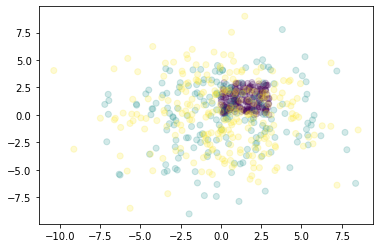

In [12]:
plt.scatter(dat.x1, dat.x2, alpha=0.2,
            c=dat.true_clust, cmap='viridis')

In [ ]:
train_x = torch.from_numpy(dat[0:])
train_y = y_train

In [52]:
# import positivity constraint
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
from gpytorch.constraints import Interval, Positive

class spatialtemporalKernel(gpytorch.kernels.Kernel):
    # the sinc kernel is stationary
    is_stationary = True
    has_lengthscale = True
    # We will register the parameter when initializing the kernel
    def __init__(self, length_prior=None, length_constraint=None,alpha_prior=None, 
                 alpha_constraint=None, delta = None, **kwargs):
        super().__init__(**kwargs)
        
        self.delta = delta
        # # register the b parameter
        # self.register_parameter(
        #     name='raw_length', parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        # )
        # register the similarity parameter
        self.register_parameter(
            name='raw_alpha', parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )

        # set the parameter constraint to be positive, when nothing is specified
        # if length_constraint is None:
        #     length_constraint = Positive()
        if alpha_constraint is None:
            alpha_constraint = Positive()
        
        # register the constraint
        # self.register_constraint("raw_length", length_constraint)
        self.register_constraint("raw_alpha", alpha_constraint)

        # set the parameter prior, see
        # https://docs.gpytorch.ai/en/latest/module.html#gpytorch.Module.register_prior
        # if length_prior is not None:
        #     self.register_prior(
        #         "length_prior",
        #         length_prior,
        #         lambda m: m.length,
        #         lambda m, v : m._set_length(v),
        #     )
        if alpha_prior is not None:
            self.register_prior(
                "alpha_prior",
                alpha_prior,
                lambda m: m.alpha,
                lambda m, v : m._set_alpha(v),
            )
        
    # now set up the 'actual' paramter
#     @property
#     def length(self):
#         # when accessing the parameter, apply the constraint transform
#         return self.raw_length_constraint.transform(self.raw_length)

#     @length.setter
#     def length(self, value):
#         return self._set_length(value)
    
#     def _set_length(self, value):
#         if not torch.is_tensor(value):
#             value = torch.as_tensor(value).to(self.raw_length)
#         # when setting the paramater, transform the actual value to a raw one by applying the inverse transform
#         self.initialize(raw_length=self.raw_length_constraint.inverse_transform(value))
#     # now set up the 'actual' paramter
    @property
    def alpha(self):
        # when accessing the parameter, apply the constraint transform
        return self.raw_alpha_constraint.transform(self.raw_alpha)

    @alpha.setter
    def alpha(self, value):
        return self._set_alpha(value)
    # now set up the 'actual' paramter
    def _set_alpha(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_alpha)
        # when setting the paramater, transform the actual value to a raw one by applying the inverse transform
        self.initialize(raw_alpha=self.raw_alpha_constraint.inverse_transform(value))
        
        
    # this is the kernel function
    def forward(self, x1, x2, **params):
        # calculate the distance between inputs
        Dnom = self.covar_dist(x1, x2, square_dist=True, **params)
        A = (self.alpha)*(self.delta)+1
        D = Dnom.div(-A)
        C = torch.exp(self.lengthscale * D)
        return C.div(A)

In [57]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 100

# Wrap training, prediction and plotting from the ExactGP-Tutorial into a function,
# so that we do not have to repeat the code later on
def train(model, likelihood, training_iter=training_iter):
    # Use the adam optimizer
    # optimizer = torch.optim.LBFGS(model.parameters())  # Includes GaussianLikelihood parameters
    optimizer = torch.optim.Adam(model.parameters(),lr=0.2) 
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    constraint = model.covar_module.base_kernel.raw_alpha_constraint
    
    # h_lbfgs = []
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f  lengthscale: %.3f  alpha: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        # constraint.transform(model.covar_module.base_kernel.raw_length),
        # constraint.transform(model.covar_module.base_kernel.raw_alpha),
        constraint.transform(model.covar_module.base_kernel.raw_lengthscale),
        constraint.transform(model.covar_module.base_kernel.raw_alpha),
        # model.covar_module.base_kernel.raw_shift.item(),
        model.likelihood.noise.item()
        ))
        optimizer.step()
        # optimizer.step(lambda: -mll(output, train_y))
        # h_lbfgs.append(objective.item())

In [61]:
from botorch import fit_gpytorch_model
def train(model, likelihood, training_iter=training_iter):
    # Use the adam optimizer
    # optimizer = torch.optim.Adam(model.parameters(),lr=0.1) 
    optimizer = torch.optim.LBFGS(model.parameters())
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    # constraint = model.covar_module.base_kernel.raw_length_constraint
    fit_gpytorch_model(mll)
    # for i in range(training_iter):
    # # Zero gradients from previous iteration
    #     optimizer.zero_grad()
    #     # Output from model
    #     output = model(train_x)
    #     # Calc loss and backprop gradients
    #     loss = -mll(output, train_y)
    #     loss.backward()
    #     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
    #         i + 1, training_iter, loss.item(),
    #         model.covar_module.base_kernel.lengthscale.item(),
    #         model.likelihood.noise.item()
    #     ))
    #     # optimizer.step()
    #     optimizer.step(lambda: -mll(output, train_y))
    return model, likelihood

# Trained on cluster 1

In [73]:
pairwise_distances = squareform(pdist(dat.iloc[0:n_samples_1,0:2]))**2
pairwise_distances
train_x = torch.tensor(np.array(dat.iloc[0:n_samples_1,2:4]))
train_y = torch.tensor(np.array(dat.y1[:n_samples_1]))
delta = torch.from_numpy(pairwise_distances)

In [74]:
# Use the simplest form of GP model, exact inference
class MGGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(spatialtemporalKernel(delta = delta))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize the new model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = MGGPModel(train_x, train_y, likelihood)

# set to training mode and train
model.train()
likelihood.train()
train(model, likelihood)

# Get into evaluation (predictive posterior) mode and predict
# model.eval()
# likelihood.eval()
# observed_pred = predict(model, likelihood)

(MGGPModel(
   (likelihood): GaussianLikelihood(
     (noise_covar): HomoskedasticNoise(
       (raw_noise_constraint): GreaterThan(1.000E-04)
     )
   )
   (mean_module): ZeroMean()
   (covar_module): ScaleKernel(
     (base_kernel): spatialtemporalKernel(
       (raw_lengthscale_constraint): Positive()
       (raw_alpha_constraint): Positive()
       (distance_module): Distance()
     )
     (raw_outputscale_constraint): Positive()
   )
 ),
 GaussianLikelihood(
   (noise_covar): HomoskedasticNoise(
     (raw_noise_constraint): GreaterThan(1.000E-04)
   )
 ))

In [75]:
model.covar_module.base_kernel.lengthscale

tensor([[0.1635]], grad_fn=<SoftplusBackward0>)

In [76]:
model.covar_module.base_kernel.alpha

tensor([[0.0117]], grad_fn=<SoftplusBackward0>)

# Trained on cluster 2

In [66]:
pairwise_distances = squareform(pdist(dat.iloc[n_samples_1:(n_samples_1+n_samples_2),0:2]))**2
pairwise_distances
train_x = torch.tensor(np.array(dat.iloc[n_samples_1:(n_samples_1+n_samples_2),2:4]))
train_y = torch.tensor(np.array(dat.y1[n_samples_1:(n_samples_1+n_samples_2)]))
delta = torch.from_numpy(pairwise_distances)

In [67]:
# initialize the new model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = MGGPModel(train_x, train_y, likelihood)

# set to training mode and train
model.train()
likelihood.train()
train(model, likelihood)

(MGGPModel(
   (likelihood): GaussianLikelihood(
     (noise_covar): HomoskedasticNoise(
       (raw_noise_constraint): GreaterThan(1.000E-04)
     )
   )
   (mean_module): ZeroMean()
   (covar_module): ScaleKernel(
     (base_kernel): spatialtemporalKernel(
       (raw_lengthscale_constraint): Positive()
       (raw_alpha_constraint): Positive()
       (distance_module): Distance()
     )
     (raw_outputscale_constraint): Positive()
   )
 ),
 GaussianLikelihood(
   (noise_covar): HomoskedasticNoise(
     (raw_noise_constraint): GreaterThan(1.000E-04)
   )
 ))

In [68]:
model.covar_module.base_kernel.lengthscale

tensor([[0.0013]], grad_fn=<SoftplusBackward0>)

In [69]:
model.covar_module.base_kernel.alpha

tensor([[0.1701]], grad_fn=<SoftplusBackward0>)

# Trained on cluster 1 and 2

In [70]:
pairwise_distances = squareform(pdist(dat.iloc[:(n_samples_1+n_samples_2),0:2]))**2
pairwise_distances
train_x = torch.tensor(np.array(dat.iloc[:(n_samples_1+n_samples_2),2:4]))
train_y = torch.tensor(np.array(dat.y1[:(n_samples_1+n_samples_2)]))
delta = torch.from_numpy(pairwise_distances)

In [71]:
# initialize the new model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = MGGPModel(train_x, train_y, likelihood)

# set to training mode and train
model.train()
likelihood.train()
train(model, likelihood)

(MGGPModel(
   (likelihood): GaussianLikelihood(
     (noise_covar): HomoskedasticNoise(
       (raw_noise_constraint): GreaterThan(1.000E-04)
     )
   )
   (mean_module): ZeroMean()
   (covar_module): ScaleKernel(
     (base_kernel): spatialtemporalKernel(
       (raw_lengthscale_constraint): Positive()
       (raw_alpha_constraint): Positive()
       (distance_module): Distance()
     )
     (raw_outputscale_constraint): Positive()
   )
 ),
 GaussianLikelihood(
   (noise_covar): HomoskedasticNoise(
     (raw_noise_constraint): GreaterThan(1.000E-04)
   )
 ))

In [72]:
print(model.covar_module.base_kernel.lengthscale.item())
print(model.covar_module.base_kernel.alpha.item())

0.03997315093874931
0.0327620692551136
